# Evaluate the performance of the logistic regression on plate 3 and 3 prime combined data

## Imports

In [1]:
import sys
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_score,
    accuracy_score,
    recall_score,
    f1_score,
    classification_report,
)
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

from joblib import dump, load

## Find the git root Directory

In [2]:
# Get the current working directory
cwd = Path.cwd()

if (cwd / ".git").is_dir():
    root_dir = cwd

else:
    root_dir = None
    for parent in cwd.parents:
        if (parent / ".git").is_dir():
            root_dir = parent
            break

# Check if a Git root directory was found
if root_dir is None:
    raise FileNotFoundError("No Git root directory found.")

# Seed and Generator for Reproducibility

In [3]:
rnd_val = 0  # Random value for all seeds
rng = np.random.default_rng(seed=rnd_val)  # random number generator

## Create Paths

In [4]:
fig_out_path = Path("model_performance_figures")

if not fig_out_path.exists():
    fig_out_path.mkdir()

models_path = Path(f"{root_dir}/1.train_models/log_reg_plate_1_cp_fs_data/data")

## Load Data

In [5]:
lr = load(models_path / "lr_model.joblib")
testdf = load(models_path / "testdf.joblib")
le = load(models_path / "label_encoder.joblib")

## Load Data

In [6]:
testdf = load(models_path / "testdf.joblib")
le = load(models_path / "label_encoder.joblib")

## Make Predictions and Report

In [7]:
# Columns to drop if they exist
drop_columns = ["label", "preds"]
drop_columns = [col for col in drop_columns if col in testdf.columns]

testdf["preds"] = lr.predict(testdf.drop(drop_columns, axis=1))
print(classification_report(testdf["label"], testdf["preds"]))

              precision    recall  f1-score   support

           0       1.00      0.83      0.91        12
           1       0.85      1.00      0.92        11

    accuracy                           0.91        23
   macro avg       0.92      0.92      0.91        23
weighted avg       0.93      0.91      0.91        23



## Resave the testdf with Predictions

In [8]:
dump(testdf, models_path / "testdf.joblib")

['/home/camo/projects/NF1_SchwannCell_data_analysis/1.train_models/log_reg_plate_1_cp_fs_data/data/testdf.joblib']

## Find Confusion Matrix

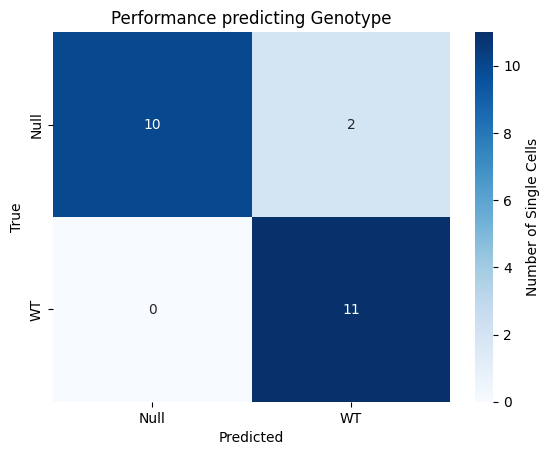

In [9]:
cm3 = pd.crosstab(
    testdf["label"], testdf["preds"], rownames=["True"], colnames=["Predicted"]
)
ax = sns.heatmap(
    cm3,
    annot=True,
    cmap="Blues",
    xticklabels=le.classes_.tolist(),
    yticklabels=le.classes_.tolist(),
)
cbar = ax.collections[0].colorbar
cbar.set_label("Number of Single Cells")
plt.title("Performance predicting Genotype")
plt.savefig(f"{fig_out_path}/lr_conf_mat.png")  # Save the Confusion Matrix

## Calculate the metrics for each Genotype

In [10]:
precision = precision_score(testdf["label"], testdf["preds"], average=None)
recall = recall_score(testdf["label"], testdf["preds"], average=None)
f1 = f1_score(testdf["label"], testdf["preds"], average=None)

df = pd.DataFrame({"recall": recall, "precision": precision, "f1_score": f1})


# Makes the columns individual values in the 'Group' column and
df = df.melt(var_name="Group", value_name="Value")

# Assigns the genotype to each row:
pos_genes = le.classes_.tolist()
df["genotype"] = pos_genes * (len(df) // len(pos_genes))

## Plot the performance of the Logistic Regression

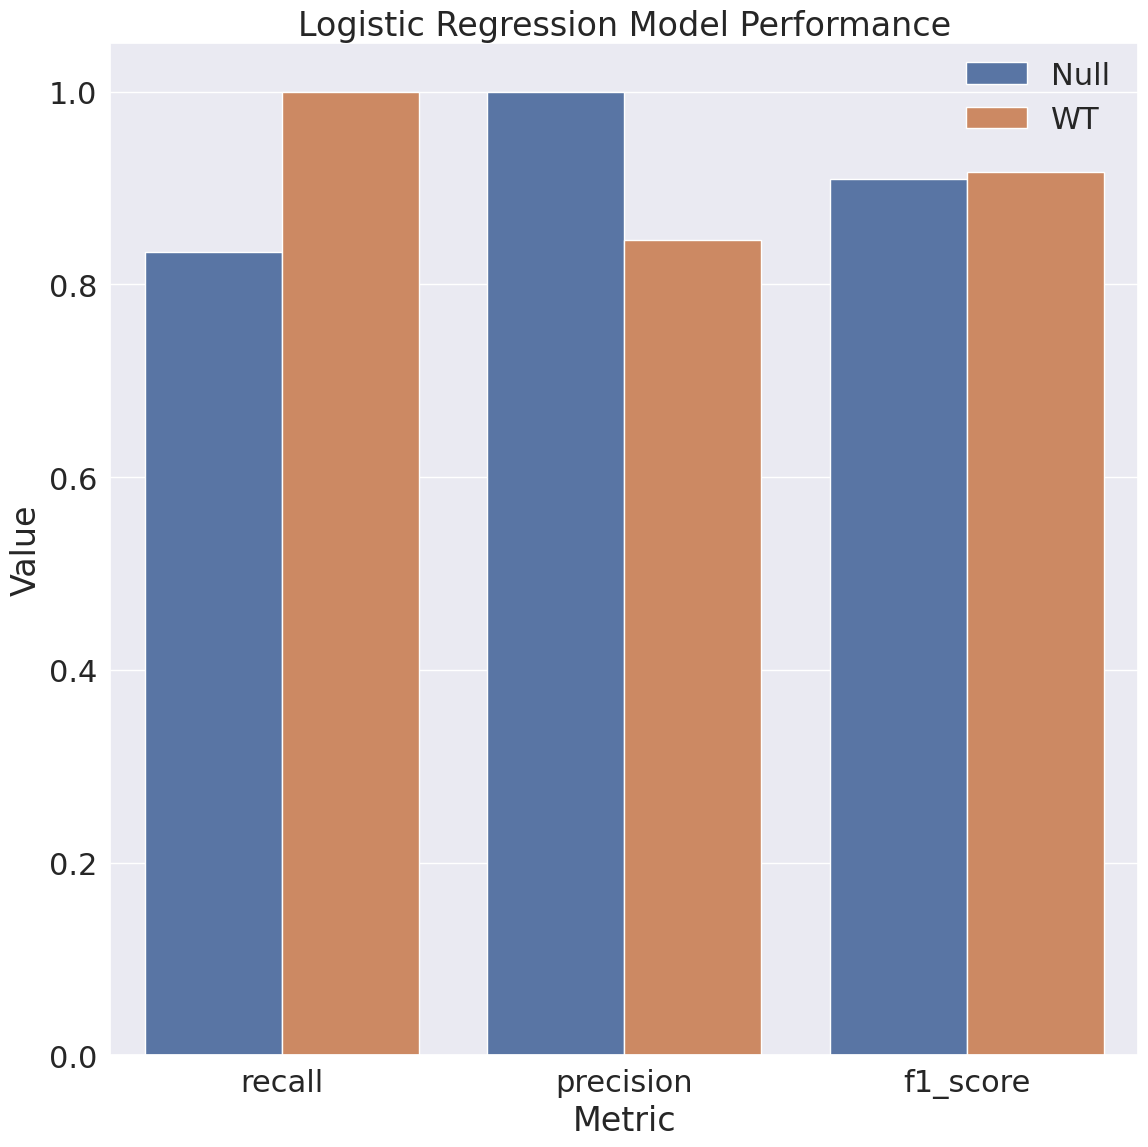

In [11]:
plt.figure(figsize=(12, 12))
sns.set(font_scale=2)
sns.barplot(x="Group", y="Value", hue="genotype", data=df)

plt.xlabel("Metric")
plt.ylabel("Value")
plt.title("Logistic Regression Model Performance")
plt.legend(loc="upper right", bbox_to_anchor=(1, 1.01), frameon=False)
plt.tight_layout()
plt.savefig(fig_out_path / "lr_performance_per_genotype_bar_plot.png")